# Generalization

## Setup device

In [11]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load data

In [13]:
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

batch_size = 32
# Original dataset (ISIC)
original_dataset = datasets.ImageFolder(root='/kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/test', transform=transform) 
original_loader = DataLoader(original_dataset, batch_size=batch_size, shuffle=False) 

# HAM10000 dataset
test_dataset = datasets.ImageFolder(root='/kaggle/input/melanoma/DermMel/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Map classes to match original dataset
test_dataset.classes = ['melanoma' if 'Melanoma' else 'benign' for cls in test_dataset.classes]
test_dataset.class_to_idx = {cls: idx for idx, cls in enumerate(test_dataset.classes)}

## Load models

In [14]:
import torch.nn as nn

def load_model(path):
    model = torch.load(path, map_location=device)
    model.to(device)
    model.eval()
    return model

model_base = load_model('/kaggle/input/aug/pytorch/default/1/model.pt')
model_aug = load_model('/kaggle/input/augmented/pytorch/default/1/augmented_model.pt')

/tmp/ipykernel_31/1306249487.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(path, map_location=device)


## Evaluate

In [15]:
import numpy as np

def evaluate_model(model, dataloader):
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)[:,1]
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

labels_base, preds_base, probs_base = evaluate_model(model_base, test_loader)
labels_aug, preds_aug, probs_aug = evaluate_model(model_aug, test_loader)

## Results

Results for Baseline model
Accuracy: 0.3460
Precision: 0.3687
Recall: 0.4331
F1 Score: 0.3983
AUC: 0.3075



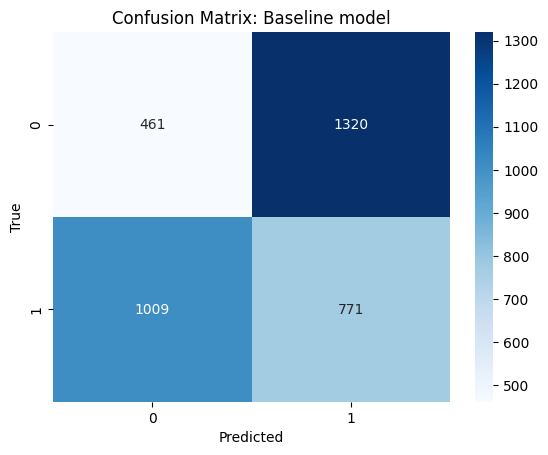

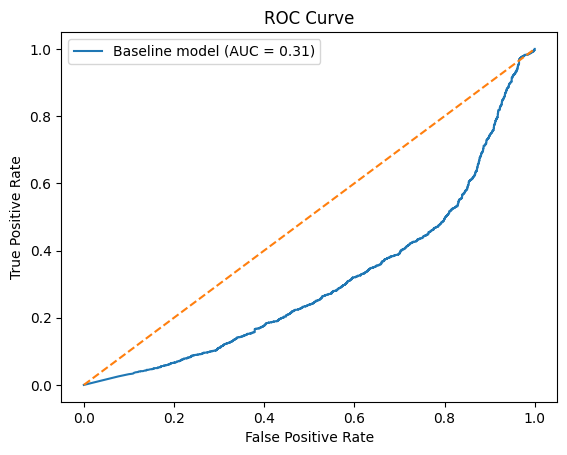

Results for Augmented model
Accuracy: 0.5161
Precision: 0.5170
Recall: 0.4865
F1 Score: 0.5013
AUC: 0.4970



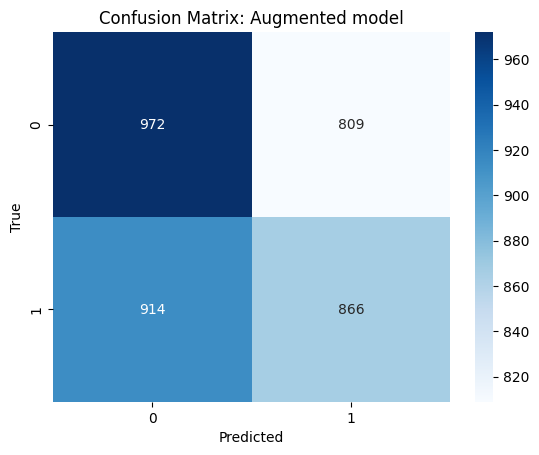

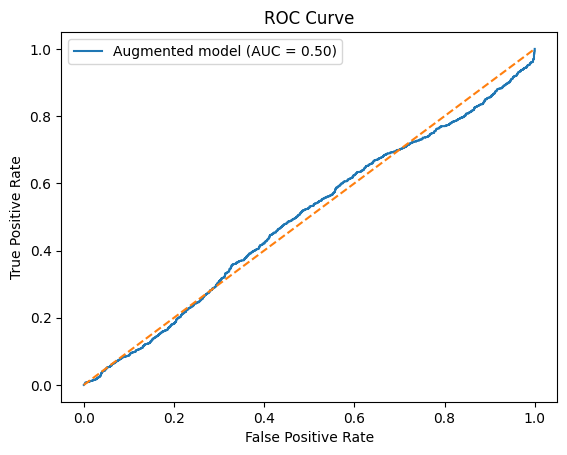

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def print_metrics(labels, preds, probs, model_name="Model"):
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds)
    rec = recall_score(labels, preds)
    f1 = f1_score(labels, preds)
    auc = roc_auc_score(labels, probs)

    # Metrics
    print(f"Results for {model_name}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")
    print()

    # Confusion Matrix
    cm = confusion_matrix(labels, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(labels, probs)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')
    plt.plot([0,1], [0,1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

print_metrics(labels_base, preds_base, probs_base, model_name="Baseline model")
print_metrics(labels_aug, preds_aug, probs_aug, model_name="Augmented model")